In [ ]:
# For colab
!pip uninstall tensorflow -y
!pip install tensorflow==2.3.1 tensorflow-quantum
!rm -rf quantum-gans
!git clone https://github.com/WiktorJ/quantum-gans
!cd quantum-gans; pip install .

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import math
import random
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider 
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [19]:
generator_layers = 4
discriminator_layers = 5
data_bus_size = 5

In [62]:
real_phase = True
generic_generator=False

In [63]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(generator_layers, discriminator_layers, data_bus_size)

In [64]:
if not generic_generator:
    gen, gs = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True)

In [65]:
if real_phase:
    real, real_symbols = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols = build_x_rotation_state(qubits=data_qubits)

In [66]:
pure_gen = gen.copy()
gen.append([disc])

In [67]:
pure_real = real.copy()
real.append([disc])

In [68]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 2): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 3): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 4): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 6): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [69]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 2): ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 3): ───────X───Z───Ry(theta0)───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                 │                                     │
(0, 4): ────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                             │                                     │
(0, 5): ────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                          │                                      │
(0, 6): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───

In [70]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(l)───Rx(d0)───Rz(d7)────ZZ────────────────Rx(d20)───Rz(d27)───ZZ────────────────Rx(d40)───Rz(d47)───ZZ────────────────Rx(d60)───Rz(d67)───ZZ────────────────Rx(d80)───Rz(d87)───ZZ────────────────
                                      │                                     │                                     │                                     │                                     │
(0, 1): ───Rx(l)───Rx(d1)───Rz(d8)────ZZ^d14───ZZ───────Rx(d21)───Rz(d28)───ZZ^d34───ZZ───────Rx(d41)───Rz(d48)───ZZ^d54───ZZ───────Rx(d61)───Rz(d68)───ZZ^d74───ZZ───────Rx(d81)───Rz(d88)───ZZ^d94───ZZ───────
                                               │                                     │                                     │                                     │                                     │
(0, 2): ───Rx(l)───Rx(d2)───Rz(d9)────ZZ───────ZZ^d17───Rx(d22)───Rz(d29)───ZZ───────ZZ^d37───Rx(d42)───Rz(d49)───ZZ───────ZZ^d57───Rx(d62)───Rz(d69)───ZZ───────ZZ^d77───Rx(d82)───Rz(d89)───ZZ───────ZZ^d97───
                                      │                                     │                                     │                                     │                                     │
(0, 3): ───Rx(l)───Rx(d3)───Rz(d10)───ZZ^d15───ZZ───────Rx(d23)───Rz(d30)───ZZ^d35───ZZ───────Rx(d43)───Rz(d50)───ZZ^d55───ZZ───────Rx(d63)───Rz(d70)───ZZ^d75───ZZ───────Rx(d83)───Rz(d90)───ZZ^d95───ZZ───────
                                               │                                     │                                     │                                     │                                     │
(0, 4): ───Rx(l)───Rx(d4)───Rz(d11)───ZZ───────ZZ^d18───Rx(d24)───Rz(d31)───ZZ───────ZZ^d38───Rx(d44)───Rz(d51)───ZZ───────ZZ^d58───Rx(d64)───Rz(d71)───ZZ───────ZZ^d78───Rx(d84)───Rz(d91)───ZZ───────ZZ^d98───
                                      │                                     │                                     │                                     │                                     │
(0, 5): ───Rx(l)───Rx(d5)───Rz(d12)───ZZ^d16───ZZ───────Rx(d25)───Rz(d32)───ZZ^d36───ZZ───────Rx(d45)───Rz(d52)───ZZ^d56───ZZ───────Rx(d65)───Rz(d72)───ZZ^d76───ZZ───────Rx(d85)───Rz(d92)───ZZ^d96───ZZ───────
                                               │                                     │                                     │                                     │                                     │
(0, 6): ───Rx(l)───Rx(d6)───Rz(d13)────────────ZZ^d19───Rx(d26)───Rz(d33)────────────ZZ^d39───Rx(d46)───Rz(d53)────────────ZZ^d59───Rx(d66)───Rz(d73)────────────ZZ^d79───Rx(d86)───Rz(d93)────────────ZZ^d99───

In [71]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [72]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [73]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [74]:
g_values = [-1, -0.5]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})

In [75]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  real, 
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = get_g_parameters_provider(),
                  use_analytical_expectation=True)

<Figure size 432x288 with 0 Axes>

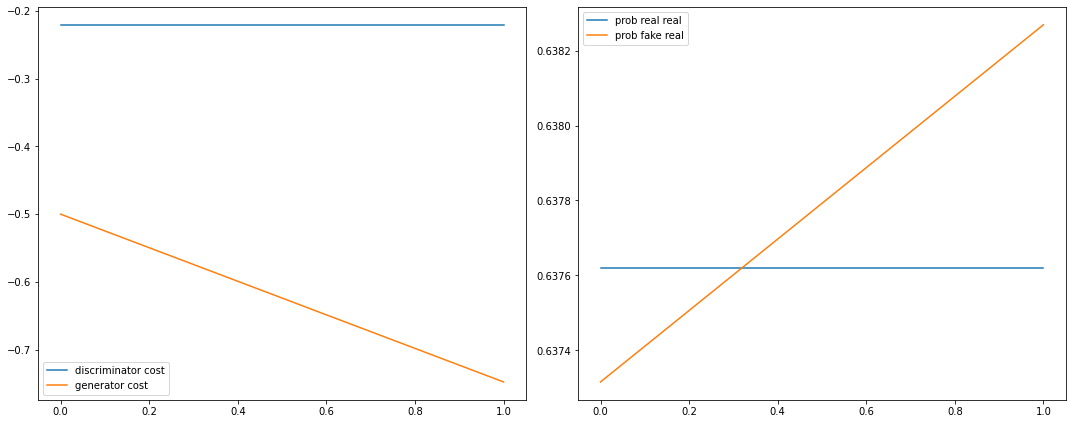

----------- AFTER GENERATOR TRAINING -----------
Epoch 0: generator cost = -0.7478705048561096
Epoch 0: discriminator cost = -0.2201215624809265
Prob(fake classified as real):  0.6382693
Prob(real classified as real):  0.6376209
-------------------------------------
----------- TRAINING DONE -----------
Weights: [
  {
    "gen_weights": [
      0.3788506090641022,
      -0.3565407693386078,
      0.3709574043750763,
      0.3835587203502655,
      -0.3424645662307739,
      0.35117021203041077,
      -0.35151854157447815,
      -0.36253300309181213,
      -0.3621211051940918,
      -0.35688161849975586,
      -0.35971200466156006,
      -0.3465891480445862,
      -0.3535420596599579
    ],
    "disc_weights": [
      -2.7548415660858154,
      -1.5434679985046387,
      4.100963115692139,
      -0.18934722244739532,
      -3.8438565731048584,
      5.214024066925049,
      -0.4174979329109192,
      -2.0984935760498047,
      4.5817766189575195,
      0.8881039619445801,
      2.213771

In [76]:
epochs = 1
disc_iteration = 10
gen_iteration = 1
snapshot_interval_epochs = 10
results = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs)

In [ ]:
def get_gen_for_g(g, gen_weights):
    rad = map_to_radians(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, gen_weights, g, size, real_provider):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights), list(range(size)))
    real = real_evaluator.get_state_from_params(real_provider(g), list(range(size)))
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights), list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
     generated1 = gen_evaluator.get_state_from_params(get_gen_for_g(g1, gen_weights), list(range(size)))
     generated2 = gen_evaluator.get_state_from_params(get_gen_for_g(g2, gen_weights), list(range(size)))
     return generated1, generated2, cirq.fidelity(generated1, generated2)

In [ ]:
trained_disc_weights = tf.Variable(np.array([ 1.25888796e+01,  1.10409822e+01,  1.27487049e+01,  1.32927475e+01,
       -3.20522385e+01,  2.98508596e+00, -7.54223883e-01,  8.97036648e+00,
        8.98472309e+00, -2.77423954e+00,  8.90891266e+00,  5.72837019e+00,
        6.03105211e+00, -4.64482594e+00, -1.10843427e-01,  7.78598115e-02,
        3.00343895e+00,  3.83781940e-01,  6.08641243e+00,  8.64131927e+00,
       -2.17593918e+01,  1.45857897e+01,  2.36893883e+01,  8.75363445e+00,
       -2.42768993e+01,  1.27688437e+01,  2.53628349e+00,  1.39768391e+01,
        1.40961084e+01, -2.04474068e+01,  4.71392822e+00,  1.66926212e+01,
        1.88311214e+01,  9.17525005e+00,  1.16109962e+01,  1.08004580e+01,
        1.10795708e+01,  5.81477690e+00, -5.50215101e+00,  2.22007637e+01,
        2.25015125e+01,  3.21826210e+01, -1.80058708e+01, -7.85126591e+00,
       -7.77073908e+00,  1.40237570e+01,  3.14071465e+01, -1.07477732e+01,
        1.55852342e+00,  2.63786411e+01,  1.31890945e+01,  7.14759350e+00,
        5.46145630e+00, -1.79730053e+01,  7.40563774e+00,  1.06135674e+01,
       -1.55095673e+00, -2.66580944e+01,  6.51995277e+00, -2.37151980e+00,
        3.51896515e+01,  1.50027342e+01,  1.80733763e-02, -1.75052185e+01,
        9.60706902e+00, -6.06413984e+00,  5.35433817e+00, -7.88707399e+00,
        1.27363043e+01,  1.02446747e+01]), dtype=tf.float32)

trained_gen_weights = np.array([ -1.6883899 ,  12.534816  ,   0.3735907 ,  -9.315787  ,
        -6.007224  , -12.969288  ,   8.700528  ,  -5.1759815 ,
         4.310844  ,  -3.130318  ,   6.798724  ,   4.905171  ,
        -0.2890863 ,  -1.222973  ,  -0.07461139,  -2.5728188 ,
         1.7303827 ,  -1.5344989 ,   2.6312382 ,  -1.8737797 ,
        -1.0022153 ,   4.3546224 ,   3.5610907 ,  -4.2001524 ,
        10.083789  , -16.943022  ,   8.448887  ,   7.81465   ,
         2.9656339 ,   0.04719266,  14.356344  ,   0.31659052,
         4.6315327 ])

gen_symbols = gs + (ls,)
# real_symbols = ('r0', 'r1', 'r2')

In [ ]:
gen_evaluator = CircuitEvaluator(pure_gen, gen_symbols)
real_evaluator = CircuitEvaluator(pure_real, real_symbols)

In [ ]:
g = 0
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, get_g_parameters_provider())

In [ ]:
g = -1
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, get_g_parameters_provider())

In [ ]:
compare_generated_for_g(gen_evaluator, -1, 0, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)